In [14]:
from recursive_clustering.models.estimator import ModularCoHiRF
from recursive_clustering.models.pseudo_kernel import PseudoKernelClustering
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively
from matplotlib import pyplot as plt
import numpy as np
import optuna
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA
from functools import partial

# Examples

## Blobs

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

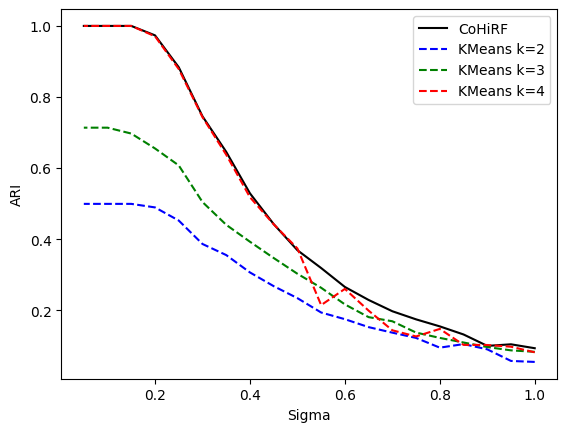

In [2]:
n_samples=1000
n_features=2
#centers = np.array([[0.5,0],[-0.5,0],[0,np.sqrt(3)/2]])
centers = np.array([[0.5,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5]])
components_size= 1
base_model = KMeans
base_model_kwargs = {'n_clusters': 2}
random_state=13
sigma_list = np.arange(1,0,-0.05)
baseline_1 = KMeans(n_clusters=2, random_state=random_state)
baseline_2 = KMeans(n_clusters=3, random_state=random_state)
baseline_3 = KMeans(n_clusters=4, random_state=random_state)
repetitiones = [3,4,5,6,7,8]
trials = 1

ari = np.empty((trials,len(sigma_list),len(repetitiones)))
baseline_1_ari = np.empty((trials,len(sigma_list)))
baseline_2_ari = np.empty((trials,len(sigma_list)))
baseline_3_ari = np.empty((trials,len(sigma_list)))
for t in tqdm(range(trials)):
    for cluster_std_, cluster_std  in tqdm(enumerate(sigma_list), total=len(sigma_list)):
        X, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std,
                                    random_state=random_state)
        X = StandardScaler().fit_transform(X)
        baseline_1.fit(X)
        baseline_2.fit(X)
        baseline_3.fit(X)
        baseline_1_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_1.labels_)
        baseline_2_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_2.labels_)
        baseline_3_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_3.labels_)
        for rep_, rep in enumerate(repetitiones):
            model = ModularCoHiRF(n_features=components_size, repetitions = rep, random_state=random_state, 
                                  base_model=base_model, base_model_kwargs=base_model_kwargs)
            model.fit(X)
            ari[t,cluster_std_, rep_] = adjusted_rand_score(true_labels, model.labels_)
            #print(f"For sigma={cluster_std}: CoHiRF score is {model.score(X)}")

plt.fill_between(sigma_list, np.quantile(ari.max(axis=2),0.1,axis=0), np.quantile(ari.max(axis=2),0.9,axis=0),color='gray', alpha = 0.1)
plt.plot(sigma_list,ari.max(axis=2).mean(axis=0),'k',label='CoHiRF')
plt.plot(sigma_list,baseline_1_ari.mean(axis=0),'b--',label='KMeans k=2')
plt.plot(sigma_list,baseline_2_ari.mean(axis=0),'g--',label='KMeans k=3')
plt.plot(sigma_list,baseline_3_ari.mean(axis=0),'r--',label='KMeans k=4')
plt.xlabel('Sigma')
plt.ylabel('ARI')
plt.legend()

## Circles (Kernel version of CoHiRF with RFF)

Text(0.5, 1.0, 'CoHiRF Random: ARI 0.014')

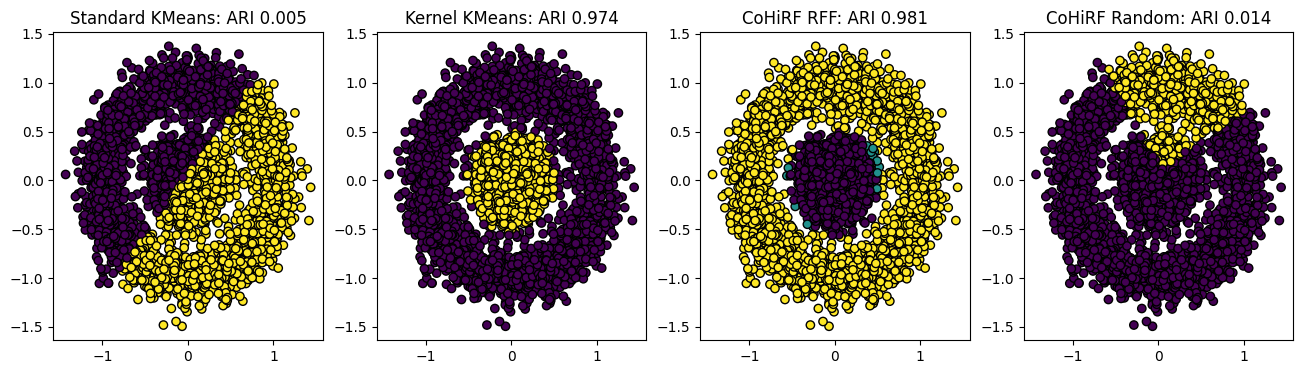

In [3]:


# dataset parameters
n_samples = 5000
factor = 0.15
noise = 0.15

# model parameters
random_state_dataset = 42
random_state_model = 2000  # currently cohirf is too dependent on the random state
kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3

features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)

baseline = KMeans(n_clusters=kmeans_n_clusters, random_state=random_state_model)

base_model = KMeans
base_model_kwargs = {'n_clusters': kmeans_n_clusters}
sampling_method = RBFSampler
sampling_kwargs = {'gamma': gamma, 'n_components': n_rff}

model_kernel = ModularCoHiRF(n_features='full', repetitions=repetitions, representative_method=representative_method,
                      base_model=base_model, base_model_kwargs=base_model_kwargs, 
                      sampling_method=sampling_method, sampling_kwargs=sampling_kwargs, random_state=random_state_model)

model_base = ModularCoHiRF(n_features='full', repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        sampling_method='random', sampling_kwargs=None, random_state=random_state_model)


kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma, random_state=random_state_model)
kmeans_kpca = KMeans(n_clusters=2, random_state=random_state_model)


plt.figure(figsize=(16, 4))
pred_labels = baseline.fit_predict(features)
plt.subplot(1, 4, 1)
plt.scatter(features[:, 0], features[:, 1], c=pred_labels, cmap='viridis', edgecolor='k')
plt.title(f'Standard KMeans: ARI {adjusted_rand_score(true_labels, baseline.labels_):.3f}')

X_kpca = kpca.fit_transform(features)
y_pred_kpca = kmeans_kpca.fit_predict(X_kpca)
plt.subplot(1, 4, 2)
# Plot the Kernel KMeans result (clustering on the original data for visualization)
plt.scatter(features[:, 0], features[:, 1], c=y_pred_kpca, cmap='viridis', edgecolor='k')
plt.title(f'Kernel KMeans: ARI {adjusted_rand_score(true_labels, y_pred_kpca):.3f}')

pred_labels = model_kernel.fit_predict(features)
plt.subplot(1, 4, 3)
plt.scatter(features[:, 0], features[:, 1], c=pred_labels, cmap='viridis', edgecolor='k')
plt.title(f'CoHiRF RFF: ARI {adjusted_rand_score(true_labels, model_kernel.labels_):.3f}')

pred_labels = model_base.fit_predict(features)
plt.subplot(1, 4, 4)
plt.scatter(features[:, 0], features[:, 1], c=pred_labels, cmap='viridis', edgecolor='k')
plt.title(f'CoHiRF Random: ARI {adjusted_rand_score(true_labels, model_base.labels_):.3f}')

# print(f'No of clusters per iteration is {model.n_clusters_iter_}') 
# print(f'Score is {model.score(features)} ')

## Spheres (Kernel version of CoHiRF with RFF)

In [4]:
def generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000):
    """
    Generate 3D data points uniformly distributed on concentric spheres with labels.
    
    Parameters:
        mean_r (list): List of mean radii for each sphere.
        std (float): Standard deviation for the radii.
        num_points_per_sphere (int): Number of points to generate per sphere.
    
    Returns:
        np.ndarray: Array of shape (N, 3), where N is the total number of points.
        np.ndarray: Array of shape (N,), containing labels for each point.
    """
    data = []
    labels = []
    
    for i, r in enumerate(mean_r):
        # Generate random radii with Gaussian distribution around the mean radius
        radii = np.random.normal(r, std, num_points_per_sphere)
        
        # Generate random points uniformly distributed on a unit sphere
        phi = np.random.uniform(0, 2 * np.pi, num_points_per_sphere)
        theta = np.arccos(np.random.uniform(-1, 1, num_points_per_sphere))
        
        # Convert spherical coordinates to Cartesian coordinates
        x = radii * np.sin(theta) * np.cos(phi)
        y = radii * np.sin(theta) * np.sin(phi)
        z = radii * np.cos(theta)
        
        # Stack the points and add to the data
        points = np.column_stack((x, y, z))
        data.append(points)
        
        # Add labels for the current sphere
        labels.extend([i] * num_points_per_sphere)
    
    
    # Combine all points and labels into single arrays
    data = np.vstack(data)
    lables = np.array(labels)
    perm = np.random.permutation(data.shape[0])
    return data[perm], lables[perm]

def visualize_3d_data(data, labels):
    """
    Visualize 3D data with colors corresponding to labels.
    
    Parameters:
        data (np.ndarray): Array of shape (N, 3), containing 3D points.
        labels (np.ndarray): Array of shape (N,), containing labels for each point.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with colors based on labels
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, s=2, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

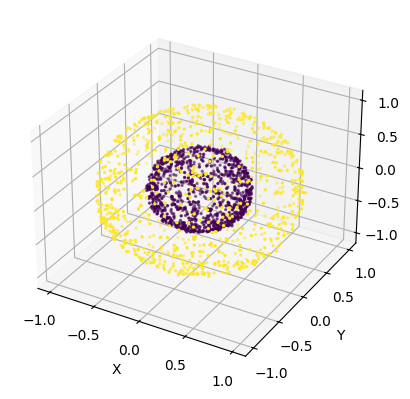

In [5]:
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000)
#features = StandardScaler().fit_transform(features)

# Visualize the data
visualize_3d_data(features, true_labels)


### Hard case

In [6]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

In [7]:
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000)

In [8]:
seed = 42
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=seed)

In [10]:
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 10),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': seed,
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-05 19:24:27,420] A new study created in memory with name: no-name-d5c1301c-59b0-4bc8-bac4-9c344321dab8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

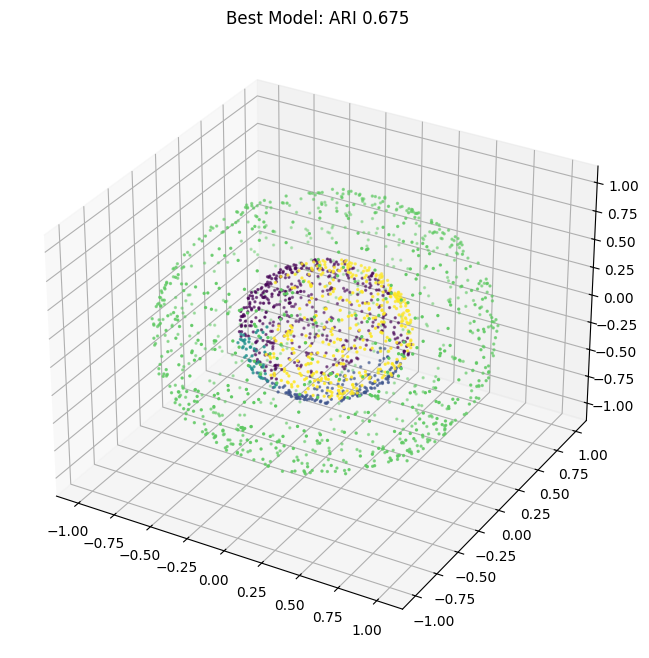

In [11]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, best_model.labels_):.3f}')
plt.show()

In [17]:
random_state = 42

# baseline
baseline = KMeans(n_clusters=2, random_state=random_state)
baseline_labels = baseline.fit_predict(features)
baseline_ari = adjusted_rand_score(true_labels, baseline_labels)

# tuner
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=seed)

# optimized kernel cohirf
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 10),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                      true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features)
ari = adjusted_rand_score(true_labels, labels)

# optimized kernel kmeans
kpca_cls = PseudoKernelClustering
kpca_search_space = {
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 10),
    }
}
kpca_kwargs = {
    'base_model': 'kmeans',
    'base_model_kwargs': {'n_clusters': 2, 'random_state': random_state},
    'sampling_method': 'kpca',
    'sampling_kwargs': {'kernel': 'rbf', 'n_components': 3, 'random_state': random_state},
}
training_fn_kpca = partial(training_fn, model_cls=kpca_cls, model_kwargs=kpca_kwargs, features=features,
                          true_labels=true_labels)
kpca_study = tuner.tune(training_fn=training_fn_kpca, search_space=kpca_search_space, direction='maximize')
best_kpca_params = kpca_study.best_params
best_kpca_params = unflatten_dict(best_kpca_params)
best_kpca_params = update_recursively(best_kpca_params, kpca_kwargs)
best_kpca_model = kpca_cls(**best_kpca_params)
kpca_labels = best_kpca_model.fit_predict(features)
kpca_ari = adjusted_rand_score(true_labels, kpca_labels)


/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-05 19:40:44,230] A new study created in memory with name: no-name-50cafce5-5719-4c43-8938-cad011ca3f14


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-05 19:41:16,331] A new study created in memory with name: no-name-3f0ca7b3-b045-4bd3-8622-ab26375c6fe8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

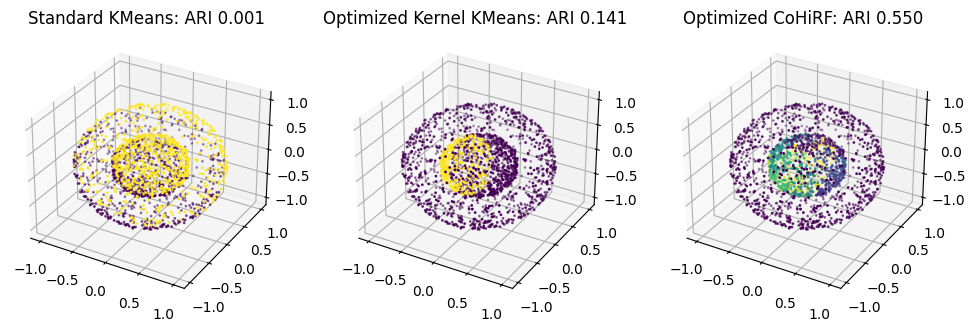

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), subplot_kw={'projection': '3d'}) 

axes[0].scatter(features[:, 0], features[:, 1], features[:, 2], c=baseline_labels, cmap='viridis', s=1)
axes[0].set_title(f'Standard KMeans: ARI {baseline_ari:.3f}')

axes[1].scatter(features[:, 0], features[:, 1], features[:, 2], c=kpca_labels, cmap='viridis', s=1)
axes[1].set_title(f'Optimized Kernel KMeans: ARI {kpca_ari:.3f}')

axes[2].scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=1)
axes[2].set_title(f'Optimized CoHiRF: ARI {ari:.3f}')
plt.show()